### SMOTE 2 Level Model

In [2]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras import optimizers
from math import sqrt
from keras.utils import to_categorical
import seaborn as sns
import keras
from keras.callbacks import ModelCheckpoint
from keras_adabound import AdaBound
from mlxtend.plotting import plot_confusion_matrix
import matplotlib
from imblearn.combine import SMOTEENN

In [3]:
df=pd.read_csv('./fdf-embedd.csv')
df = df.drop(df.columns[0], axis=1)
df=df.fillna(-1)

In [4]:
df["nDate"]=pd.to_datetime(df.date,format='%Y-%m-%d')

In [5]:
df.loc[df['clicks_level']==2, 'clicks_level'] =1

In [6]:
df["date"]=df.date.astype(str)
df["Year"]=df.date.str[:4]
df["Month"]=df.date.str[5:7]
df["Day"]=df.date.str[8:]


df["Year"]=df.Year.astype(int)
df["Month"]=df.Month.astype(int)
df["Day"]=df.Day.astype(int)

In [6]:
labels=df["clicks_level"]
df=df.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)

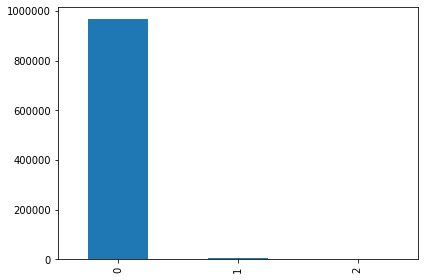

In [7]:
pd.value_counts(labels).plot.bar()
plt.tight_layout()

In [8]:
# split into train and test sets
# values = scaled
values=df.values
y=labels.copy()
n_train_hours=880874 
train_X ,train_y= values[:n_train_hours, :],y[:n_train_hours]
test_X,test_y = values[n_train_hours:, :],y[n_train_hours:]

In [10]:
from imblearn.ensemble import RUSBoostClassifier
clf = RUSBoostClassifier(random_state=0)
clf.fit(train_X,train_y)

RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=0, replacement=False,
                   sampling_strategy='auto')

In [11]:
ypred=clf.predict(test_X)
from sklearn.metrics import classification_report
print(classification_report(test_y, ypred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     92427
           1       0.10      0.90      0.19      1401

    accuracy                           0.88     93828
   macro avg       0.55      0.89      0.56     93828
weighted avg       0.98      0.88      0.93     93828



In [15]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=test_y.tolist(), predict_vector=ypred)
print (cm)

Predict     0           1           
Actual
0           81554       10873       

1           137         1264        





Overall Statistics : 

95% CI                                                            (0.8806,0.88472)
ACC Macro                                                         0.88266
AUNP                                                              0.89229
AUNU                                                              0.89229
Bennett S                                                         0.76532
CBA                                                               0.49325
CSI                                                               0.44352
Chi-Squared                                                       7543.13052
Chi-Squared DF                                                    1
Conditional Entropy                                               0.52163
Cramer V                                                          0.28354
Cross Entropy                    

In [9]:
# SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(train_X, train_y)

In [23]:
# # SMOTETEEN
# sm = SMOTEENN(random_state=42)
# X_train_sm, y_train_sm = sm.fit_sample(train_X, train_y)

In [10]:
np.unique(y_train_sm, return_counts=True)

(array([0, 1, 2]), array([873338, 873338, 873338]))

In [19]:
from sklearn.ensemble import AdaBoostClassifier
def adaboost(X_train, X_test, y_train):
    model = AdaBoostClassifier(n_estimators=10, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    prob=model.predict_proba(X_test)
    return model,y_pred,prob

model,y_smote,prob = adaboost(X_train_sm, test_X, y_train_sm)

In [28]:
df['Level1']=model.predict(df.values)

In [30]:
newdf=df[df['Level1']==1]

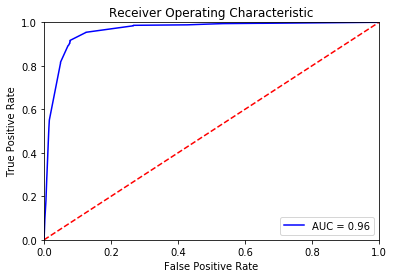

In [25]:
prob=model.predict_proba(test_X)
preds = prob[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_y, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [13]:
print (sklearn.metrics.f1_score(test_y,y_smote,average='macro'))
print (sklearn.metrics.accuracy_score(test_y,y_smote))

0.6102551935345832
0.9234770004689432


In [14]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=test_y.tolist(), predict_vector=y_smote)
print (cm)

Predict     0           1           
Actual
0           85381       7046        

1           134         1267        





Overall Statistics : 

95% CI                                                            (0.92178,0.92518)
ACC Macro                                                         0.92348
AUNP                                                              0.91406
AUNU                                                              0.91406
Bennett S                                                         0.84695
CBA                                                               0.53809
CSI                                                               0.48948
Chi-Squared                                                       11720.78931
Chi-Squared DF                                                    1
Conditional Entropy                                               0.38975
Cramer V                                                          0.35344
Cross Entropy                  

In [15]:
from sklearn.metrics import classification_report
print(classification_report(test_y, y_smote, target_names=['0','1']))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     92427
           1       0.16      0.89      0.27      1401

    accuracy                           0.93     93828
   macro avg       0.58      0.91      0.62     93828
weighted avg       0.99      0.93      0.95     93828



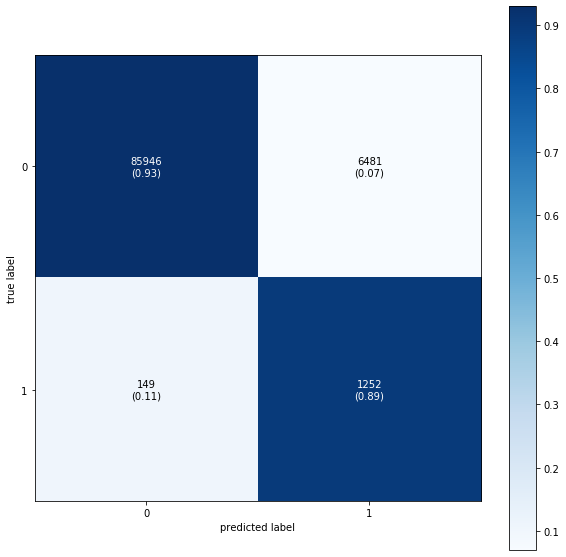

In [14]:
conf=sklearn.metrics.confusion_matrix(test_y,y_smote,labels=[0,1])
fig, ax = plot_confusion_matrix(conf_mat=conf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               figsize=(10,10))

In [11]:
train_y = to_categorical(y_train_sm)
test_y=to_categorical(test_y)



train_X = X_train_sm.reshape((X_train_sm.shape[0], 1, X_train_sm.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2620014, 1, 65) (2620014, 3) (93828, 1, 65) (93828, 3)


In [13]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3, activation='softmax'))
opt=keras.optimizers.Adam(learning_rate=0.1,amsgrad=True)


model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])


filepath='./models/weight-best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


# fit network
history = model.fit(train_X, train_y, epochs=5, batch_size=128,callbacks=callbacks_list,validation_data=(test_X, test_y),shuffle=False)

Train on 2620014 samples, validate on 93828 samples
Epoch 1/5
2620014/2620014 [==============================] - 71s 27us/step - loss: 1.4848 - categorical_accuracy: 0.9962 - val_loss: 322.5827 - val_categorical_accuracy: 0.0052

Epoch 00001: val_categorical_accuracy improved from -inf to 0.00524, saving model to ./models/weight-best.hdf5
Epoch 2/5
2620014/2620014 [==============================] - 71s 27us/step - loss: 0.0422 - categorical_accuracy: 0.9954 - val_loss: 11.7991 - val_categorical_accuracy: 0.0052

Epoch 00002: val_categorical_accuracy did not improve from 0.00524
Epoch 3/5
 178048/2620014 [=>............................] - ETA: 1:03 - loss: 0.1367 - categorical_accuracy: 0.9828

KeyboardInterrupt: 

In [17]:
ypred=model.predict(test_X)
ypred=np.argmax(ypred,axis=1)
test_y=np.argmax(test_y,axis=1)

In [18]:
print (sklearn.metrics.f1_score(test_y,ypred,average='macro'))
print (sklearn.metrics.accuracy_score(test_y,ypred))

0.003477523324851569
0.005243637293771582


/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


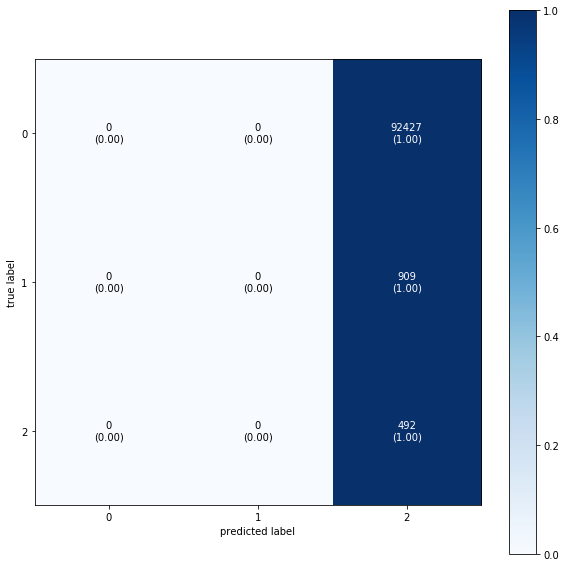

In [19]:
conf=sklearn.metrics.confusion_matrix(test_y,ypred,labels=[0,1,2])
fig, ax = plot_confusion_matrix(conf_mat=conf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               figsize=(10,10))